# Face Detection on Preprocessed Images

We are going to explore briefly the combination of face-detection on preprocessed images.  

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import our tools
import sys
sys.path.append('/Users/will/Github/facial-keypoint-detection/scripts')

# Import submit module from our tools subfolder
from tools import getdata

In [2]:
# Load data (no dev)
_loaded = getdata.load_data(0, test=False, nonas=False)

FEATURES = _loaded['features']
print 'Number of features:', len(FEATURES)

train_data = _loaded['training']['data']
train_labels = _loaded['training']['labels']
print 'Training dataset size: ', train_data.shape

Number of features: 30
Training dataset size:  (7049,)


## Challenges of Face Detection  
As seen on `face-tect.ipynb` the face detector works, but not entirely well for all cases.

In [3]:
def plot_faces(faces):
    ''' Plots a bunch of faces '''
    fig, axes = plt.subplots(1,len(faces), figsize=(18,4))
    for i,face in enumerate(faces):
        axes[i].imshow(train_data[face].reshape(96,96), cmap=plt.cm.gray)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
import cv2

In [24]:
CASC_PATH = '../haarcascade_frontalface_default.xml'

# Create the haar cascade classifier
faceCascade = cv2.CascadeClassifier(CASC_PATH)

def detect_face(img, min_face_size):
    ''' Detect faces in the image'''
    face = faceCascade.detectMultiScale(
        img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(min_face_size, min_face_size),
        flags = cv2.cv.CV_HAAR_SCALE_IMAGE)
    return face

In [25]:
def plot_face_detect(faces, min_face_size=10):
    ''' Plots a bunch of faces '''
    fig, axes = plt.subplots(1,len(faces), figsize=(18,4))
    
    for i,face in enumerate(faces):
        img = train_data[face].reshape(96,96)

        # Detect faces
        face = detect_face(img, min_face_size)

        # Plot image and rectangle on the face detected
        axes[i].imshow(img, cmap=plt.cm.gray)
        axes[i].axis('off')
        for (x,y,w,h) in face:
            _rect = patches.Rectangle( (x,y), w, h, fill=False, color='orange', lw=3)
            axes[i].add_patch(_rect)
    
    plt.tight_layout()
    plt.show()

We will the following faces:
* a "standard" full-frontal face
* a partial face
* a poor quality difficult full frontal face
* a small full frontal face

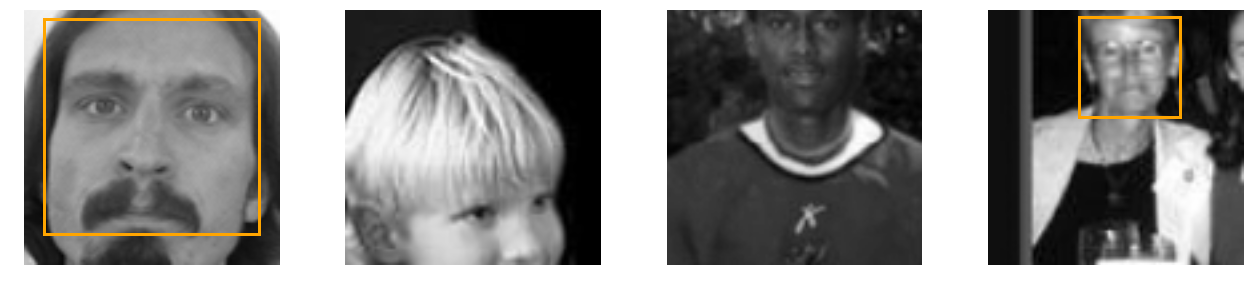

In [72]:
plot_face_detect([0, 2453, 3510, 6765], min_face_size=5)

The first two faces are not recognized by the face detector. The first one might be more difficult, since it is not a full frontal face. However, the second one should be recognize...

## Image Preprocessing

Let us experiment with the filters and edge detectors we used on `image-processing.ipynb` to see if we can improve the accuracy.

In [29]:
from skimage.filters import sobel, laplace, gaussian
from skimage.feature import hog

In [43]:
def reformat(img):
    ''' Transforms from 0-1 float pixel image to uint8 '''
    np.max(img)
    _max_value = np.max(img)
    return np.array( img * 255 / _max_value , dtype=np.uint8 )


In [55]:
def plot_transform_face_detect(faces, transform, min_face_size=5):
    ''' Plots the original and transformed image of the specified faces '''
    fig, axes = plt.subplots(3,len(faces), figsize=(18,8))
    
    for i, f in enumerate(faces):

        # Plot original
        _img = train_data[f].reshape(96,96)
        axes[0, i].imshow(_img, cmap=plt.cm.gray)
        axes[0, i].axis('off')
        
        # Transform and plot
        _tr = transform(_img)        

        axes[1, i].imshow(_tr, cmap=plt.cm.gray)
        axes[1, i].axis('off')

        # Detect faces and plot
        preprocs = reformat(_tr)
        face = detect_face(preprocs, min_face_size)

        axes[2, i].imshow(_img, cmap=plt.cm.gray)
        axes[2, i].axis('off')
        print len(face)
        for (x,y,w,h) in face:
            _rect = patches.Rectangle( (x,y), w, h, fill=False, color='orange', lw=3)
            axes[2, i].add_patch(_rect)
        

### Laplace Transform on Gaussian Blur

In [45]:
lap_gauss = lambda x: laplace(gaussian(x, sigma=2, mode='mirror'))

0
0
0
0


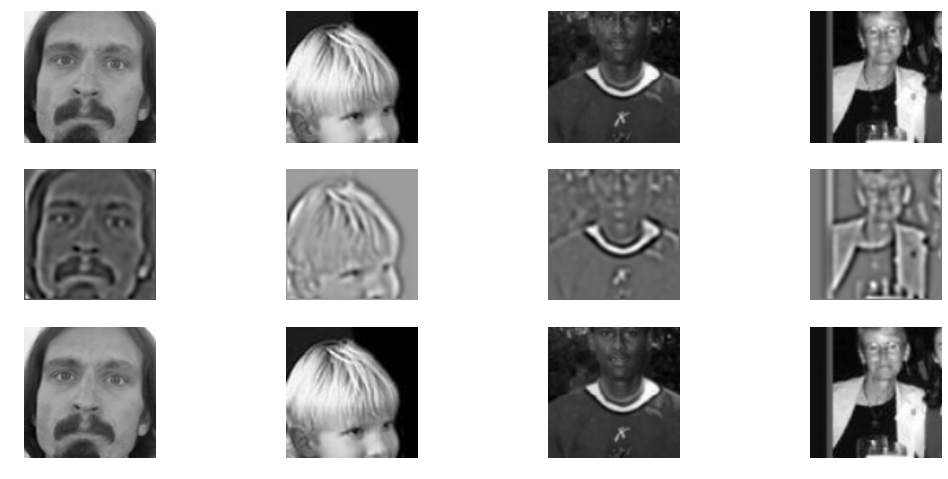

In [71]:
plot_transform_face_detect([0, 2453, 3510, 6765], lap_gauss)

### Detect on Sobel

0
0
0
0


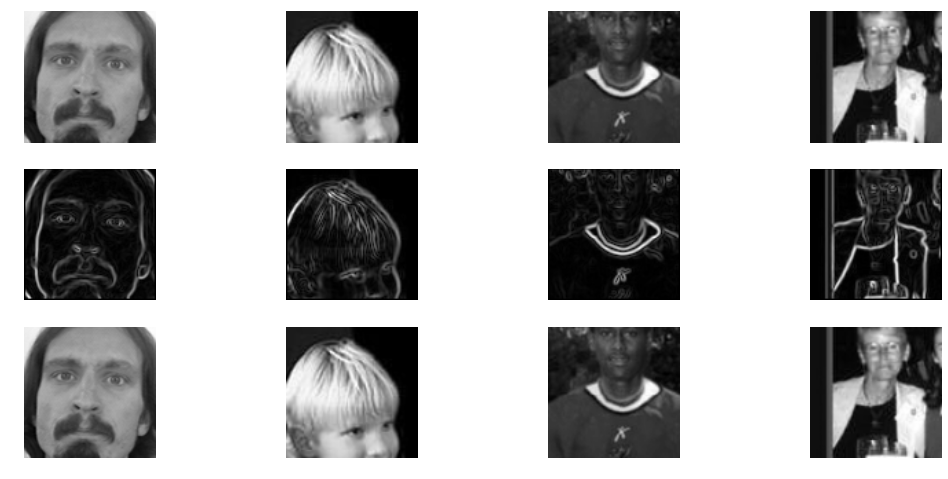

In [70]:
plot_transform_face_detect([0, 2453, 3510, 6765], sobel)

### Gaussian Blur on HOG

In [66]:
def get_hog(img):
    ''' Perform Histogram of Oriented Gradients '''
    # Histogram of Oriented Gradients (HOG)
    _, _hog = hog(img, orientations=8, pixels_per_cell=(5, 5),
                    cells_per_block=(1, 1), visualise=True)
    return _hog


In [67]:
gauss_hog = lambda x: gaussian(get_hog(x), sigma=1, mode='mirror')

0
0
0
0


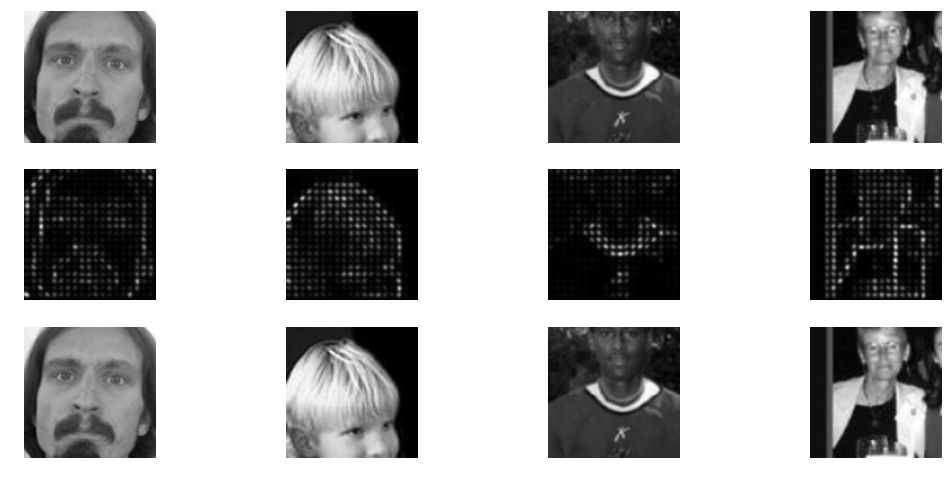

In [69]:
plot_transform_face_detect([0, 2453, 3510, 6765], gauss_hog)

It seems our attempts have not been succesful on this exploration.